## Modules
Needed to use non-Python functionalities already programmed by someone else.

In [1]:
# Used to cast the polygons into np.arrays and afterwards transpose them easily with the .T function
import numpy as np
import matplotlib.pyplot as plt    # to plot the counties
# Used to determine which part of the plot should be saved
from matplotlib.transforms import Bbox

# Used to underline text in plots
from matplotlib import rc
# To add a colorbar to the plot of the matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Used to navigate the directories and check for files
import os
# backup directory of this file, because the working directory is changed to save files
cor_mx_by_pop_density_districts_directory = os.getcwd()

## Get the Data
Read the file ["Readme.ipynb"](Readme.ipynb) or check out the files ["get_data.ipynb"](get_data.ipynb) and ["get_geographical_data_of_german_counties.ipynb"](get_geographical_data_of_german_counties.ipynb) for more information about the data collection.

In [2]:
os.chdir(".."), os.chdir("..")   # move two directories up
%run color_scheme.ipynb
os.chdir("collect_data")
%run get_data.ipynb
os.chdir(cor_mx_by_pop_density_districts_directory)    # return to original directory

Polished county data from file is ready to go!
Polished covid19 data from file is ready to go!


## Function to calculate the probability of correlations between two arrays

In [3]:
def sort_AdmUnitIDs_by_population_density():
    districts_by_population_density = dict()
    for districtID, district in districts.items():
        if district['population_density'] in districts_by_population_density.keys():
            raise Exception("The population density " + str(district['population_density']) +
                            "seems to be related to two counties")
        else:
            districts_by_population_density[district['population_density']] = districtID
    pop_densitys = list(districts_by_population_density.keys())
    pop_densitys.sort()
    return [districts_by_population_density[e] for e in pop_densitys]

In [4]:
# AdmUnitIds = list(covid19.keys())
AdmUnitIds = sort_AdmUnitIDs_by_population_density()

In [5]:
districtIDs_sorted_by_pop_density = "\\begin{enumerate}[itemsep=-6mm]\n"
for districtID in AdmUnitIds:
    district_names = non_county_specific_data["district_names"]
    states_with_districts = [e[:-1] for e in district_names.keys()]
    # take state name instead of district, because state has no districts
    if districtID[:-1] in states_with_districts:
        district_name = non_county_specific_data["district_names"][districtID]
    else:
        district_name = non_county_specific_data["states"][districtID[:-1]]
    pop_density=districts[districtID]["population_density"]
    districtIDs_sorted_by_pop_density += "\item "+districtID+" "+district_name+" ("
    districtIDs_sorted_by_pop_density += "%.2f" % pop_density
    districtIDs_sorted_by_pop_density += r" Einwohner pro km$^2$)"+"\n" 
districtIDs_sorted_by_pop_density += "\end{enumerate}"

os.chdir(".."), os.chdir(".."), os.chdir("..")    # move to correct directory
# check if the needed directory is available - otherwise create it
if not(os.path.isdir("results")): os.makedirs("results")
if not(os.path.isdir("results/Anhang")): os.makedirs("results/Anhang")
with open("results/Anhang/districtIDs_sorted_by_pop_density.tex", "w") as file:
    file.write(districtIDs_sorted_by_pop_density)
os.chdir(cor_mx_by_pop_density_districts_directory)    # return to original directory

In [6]:
def get_correlation_matrix(get_max_correlation_not_sum = True, max_shift = 50):
    correlation_matrix = [[0 for c2 in range(len(AdmUnitIds))]
                          for c1 in range(len(AdmUnitIds))]
    for AdmUnitId in AdmUnitIds:
        for second_AdmUnitId in AdmUnitIds:
            i1, i2 = (AdmUnitIds.index(AdmUnitId), AdmUnitIds.index(second_AdmUnitId))
            # if AdmUnitId1 == AdmUnitId2: continue
            if (correlation_matrix[i1][i2] != 0): continue    # Already set
            correlation = districts[AdmUnitId]["correlation"][second_AdmUnitId].copy()
            offset = max_shift + 1
            while get_max_correlation_not_sum and abs(offset) > max_shift:
                # get the shift with the highest correlation probability
                offset = non_county_specific_data[
                    "correlation_position_array2_to_array1"][np.argmax(correlation)]
                correlation[np.argmax(correlation)] = 0
            if not(get_max_correlation_not_sum):    # sum up all probabilities
                lc = len(correlation)//2
                offset = ((-sum(correlation[lc-max_shift:lc]) +
                          sum(correlation[lc+1:lc+max_shift+1]))/lc)
            correlation_matrix[i1][i2] = offset
            correlation_matrix[i2][i1] = -offset
    return correlation_matrix

In [7]:
correlation_matrizes = list()
matrix_configurations = [(False, 14), (True, 14), (False, 30), 
                         (True, 30),(False, 50), (True, 50)]
for config in matrix_configurations:
    correlation_matrizes.append(get_correlation_matrix(config[0], config[1]))

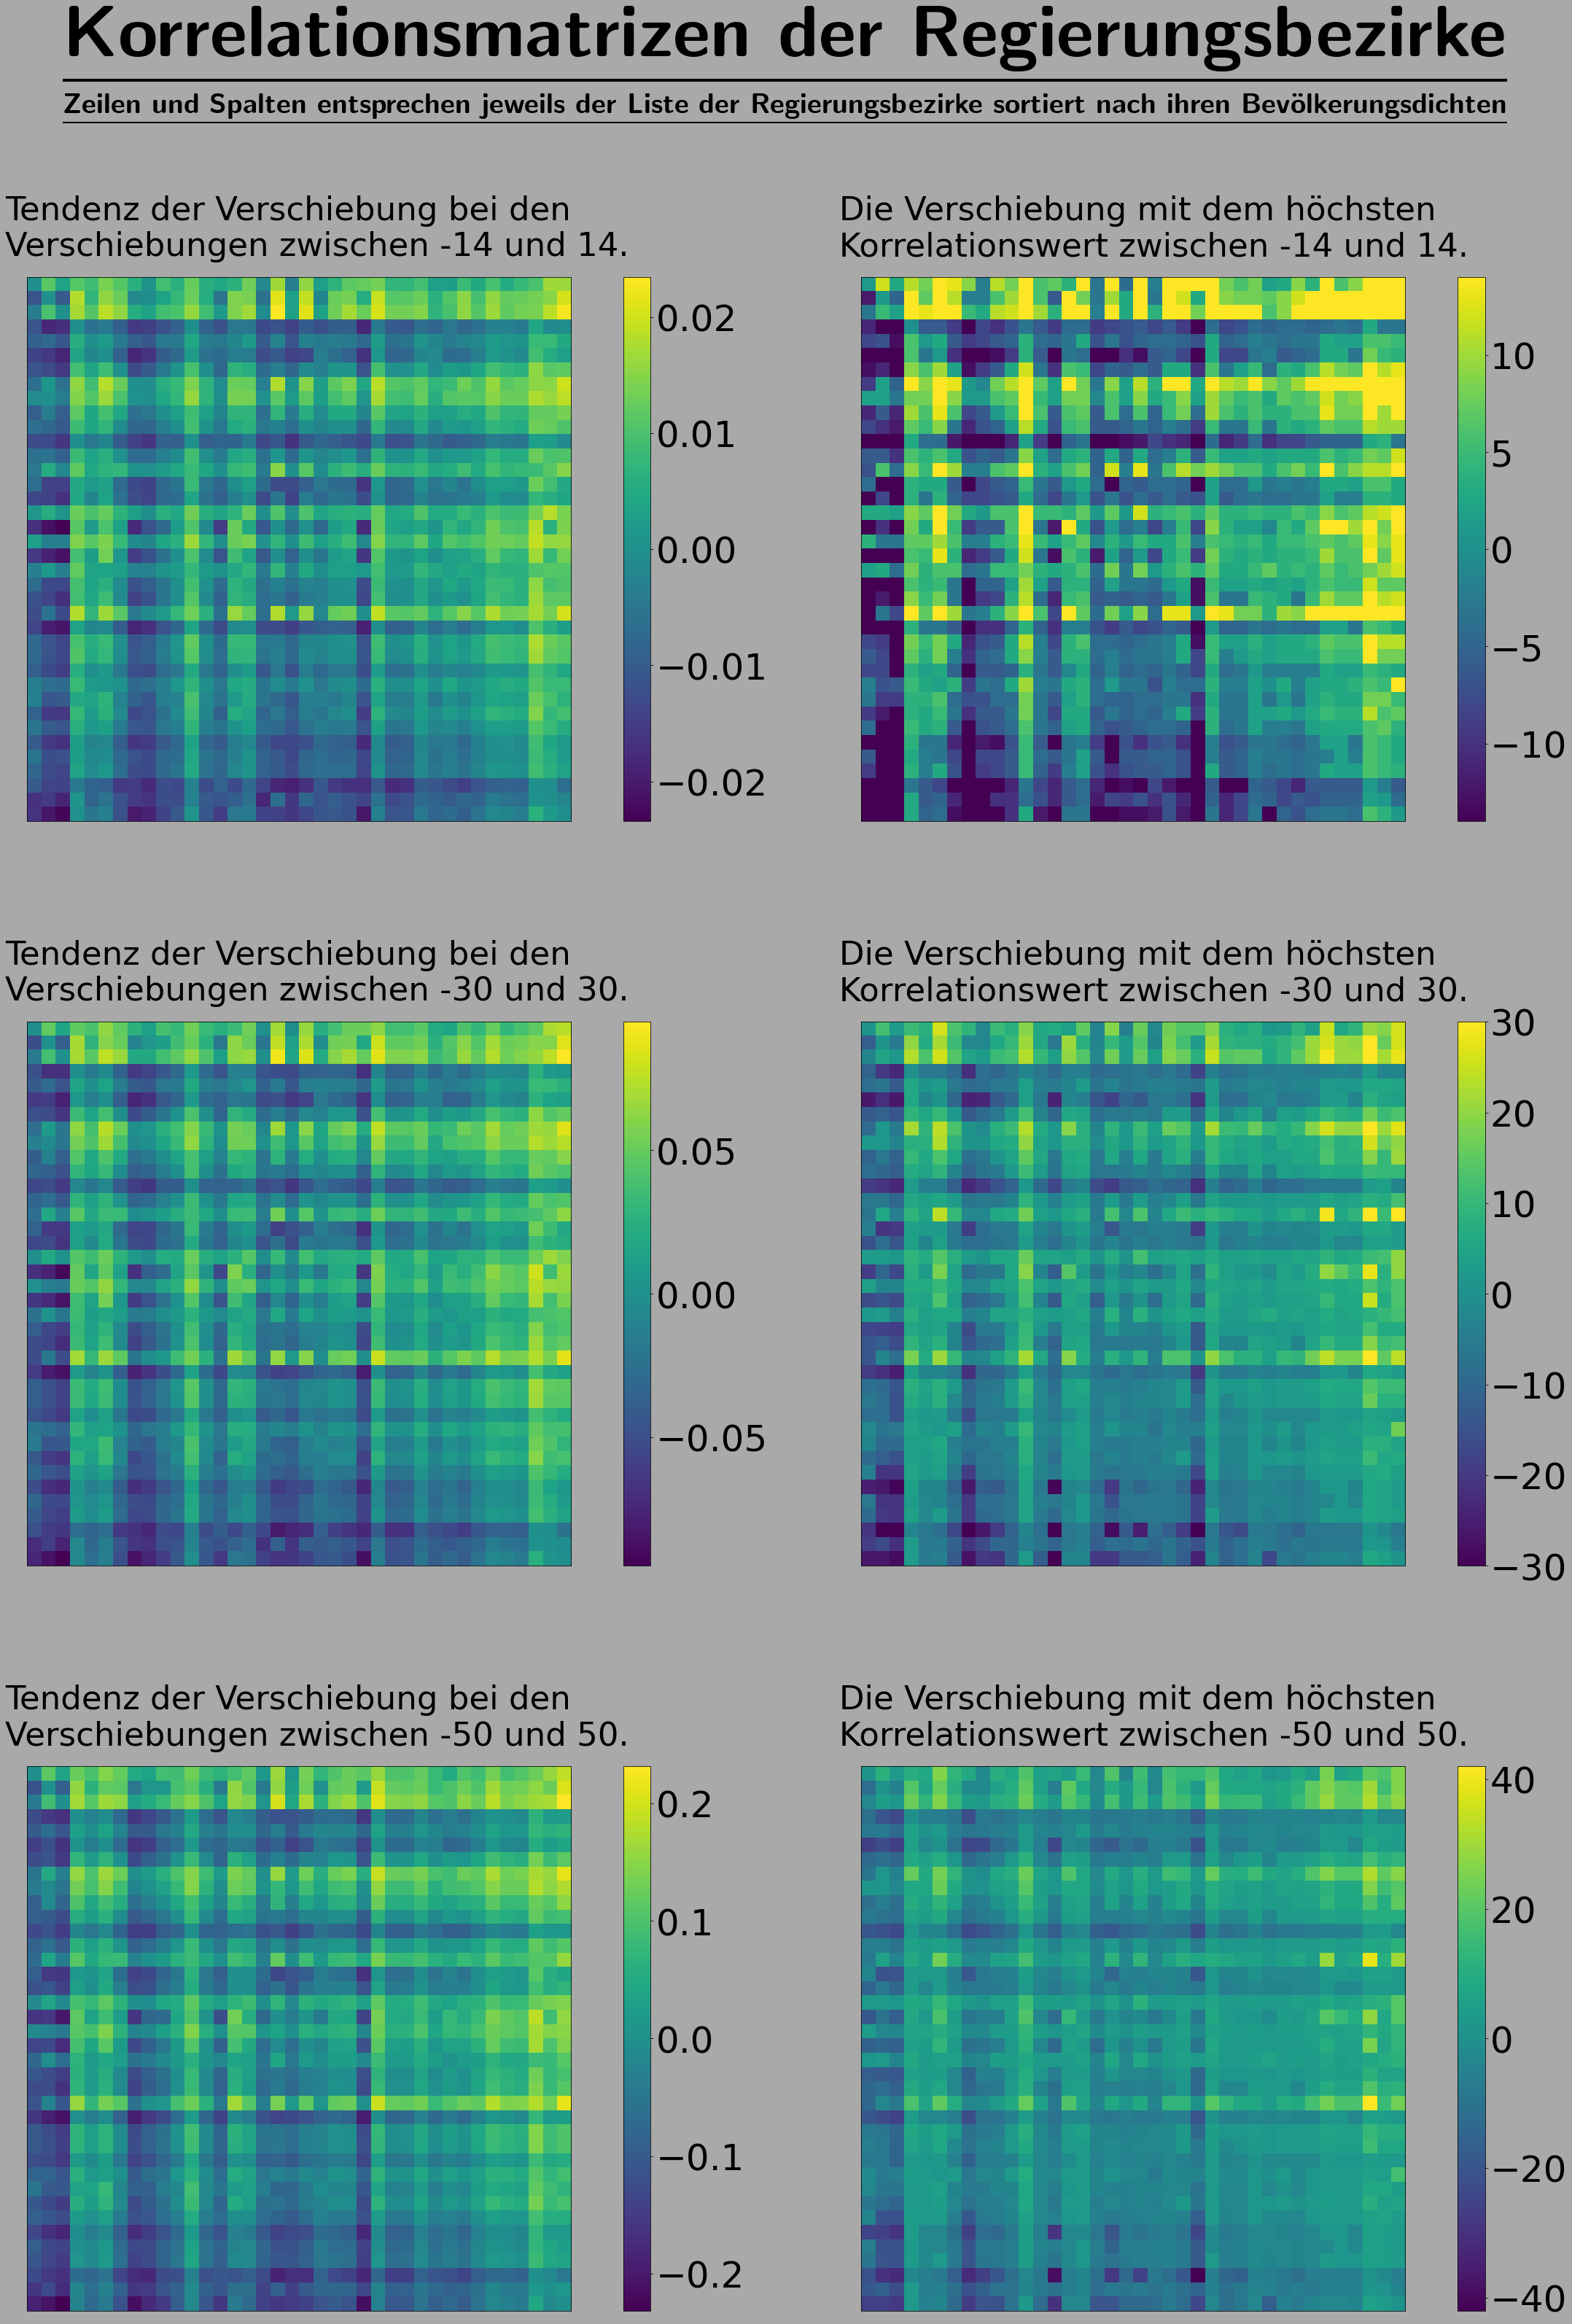

In [8]:
fig, ax = plt.subplots(3, 2, figsize = (30, 46), facecolor='darkgrey')

ax[0][0].text(2,-16,r'\textbf{\underline{Korrelationsmatrizen der Regierungsbezirke}}',
              fontsize=100, usetex=True)
ax[0][0].text(2,-12,r"\textbf{\underline{Zeilen und Spalten entsprechen }}" +
              r"\textbf{\underline{jeweils der Liste der Regierun}}" +
              r"\textbf{\underline{gsbezirke sortiert nach ihren Bevölkerungsdichten}}",
              fontsize=39, usetex=True)

i = 0
for correlation_matrix in correlation_matrizes:
    axis = ax[i//2][i%2]
    im1 = axis.matshow(correlation_matrix, interpolation='None')
    if matrix_configurations[i][0]:
        shift = str(matrix_configurations[i][1])
        axis.text(-2,-2,"Die Verschiebung mit dem höchsten\n" +
                        "Korrelationswert zwischen -"+shift+" und "+shift+".",
                        fontsize=45)
    else:
        shift = str(matrix_configurations[i][1])
        axis.text(-2,-2,"Tendenz der Verschiebung bei den\n" +
                       "Verschiebungen zwischen -"+shift+" und "+shift+".",
                       fontsize=45)
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('right', size='5%', pad=1)
    axis.axes.get_xaxis().set_visible(False)
    axis.axes.get_yaxis().set_visible(False)
    cbar = fig.colorbar(im1, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=50)
    i+=1

os.chdir(".."), os.chdir(".."), os.chdir("..")    # move to correct directory
# check if the needed directory is available - otherwise create it
if not(os.path.isdir("results")): os.makedirs("results")
if not(os.path.isdir("results/Ergebnisse")): os.makedirs("results/Ergebnisse")
fig.tight_layout(w_pad=-100)
plt.savefig("results/Ergebnisse/matrizes_pop_density_districts_vertical.png")
os.chdir(cor_mx_by_pop_density_districts_directory)    # return to original directory

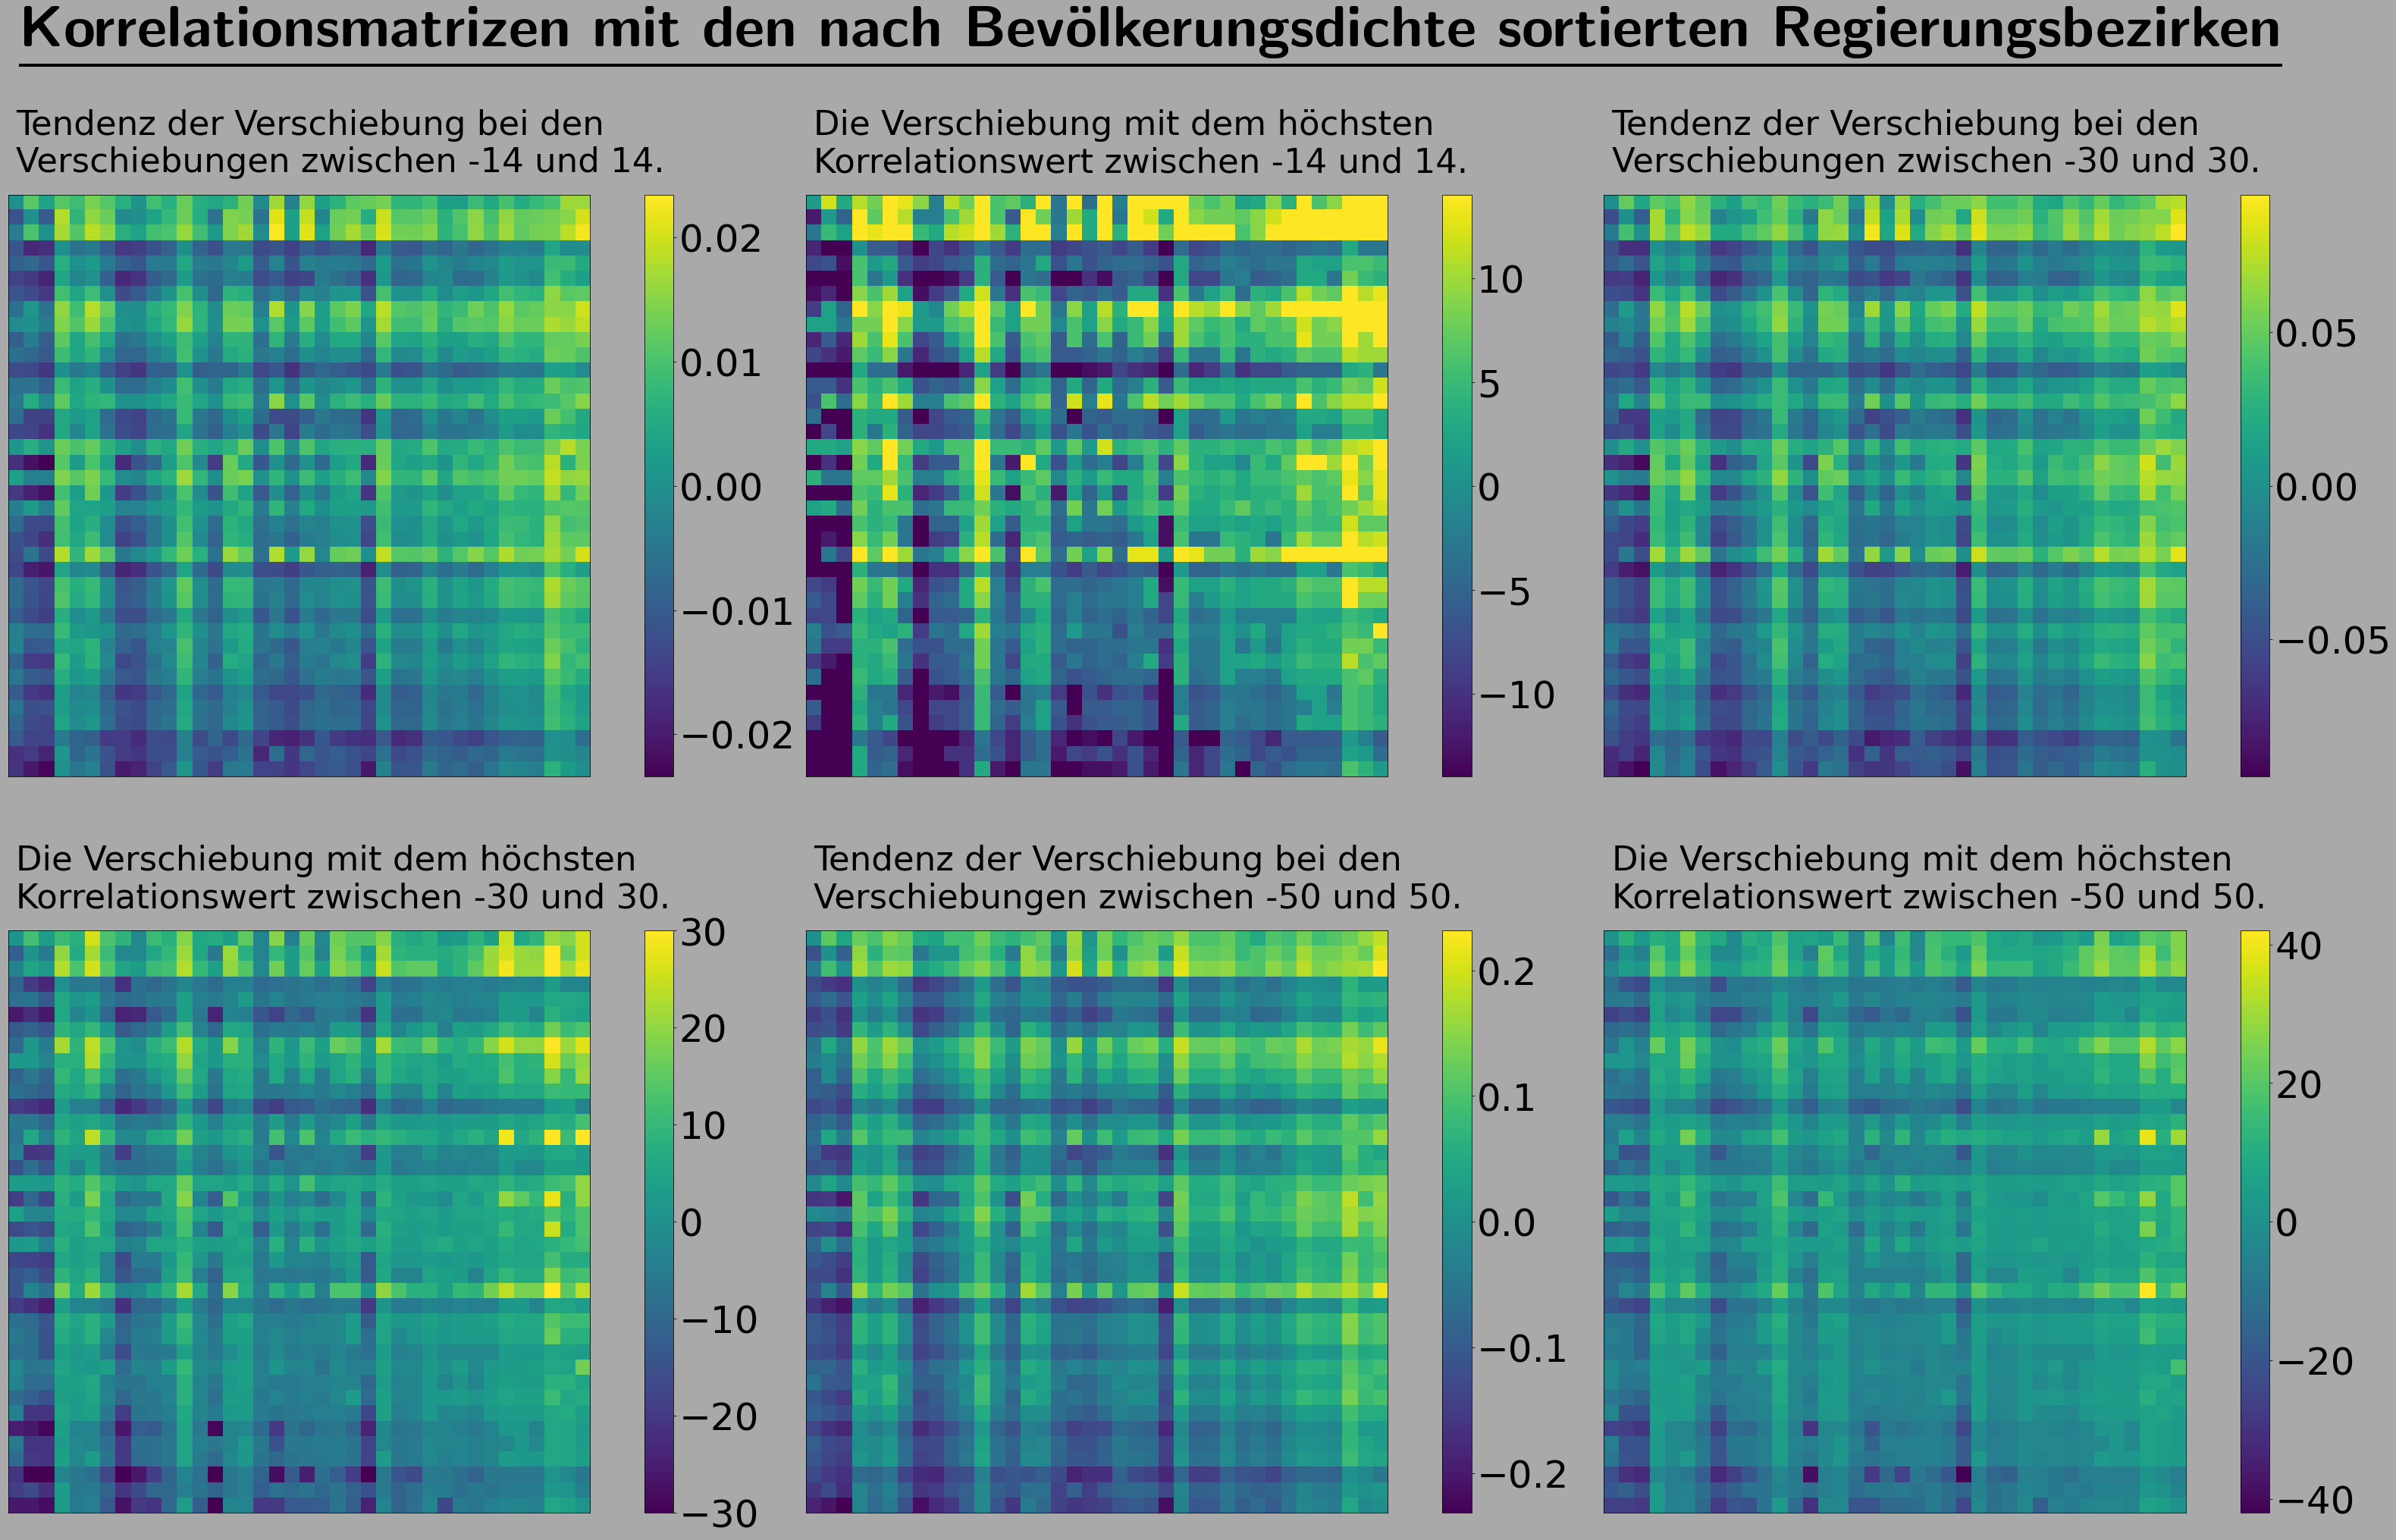

In [9]:
fig, ax = plt.subplots(2, 3, figsize = (44, 29), facecolor='darkgrey')

plt.suptitle(r"\textbf{\underline{Korrelationsmatrizen mit den nach " +
             r"Bevölkerungsdichte sortierten Regierungsbezirken}}",
             fontsize= 77, usetex=True, y=1, x=0.48)

i = 0
for correlation_matrix in correlation_matrizes:
    axis = ax[i//3][i%3]
    im1 = axis.matshow(correlation_matrix, interpolation='None')
    if matrix_configurations[i][0]:
        shift = str(matrix_configurations[i][1])
        axis.text(0,-2,"Die Verschiebung mit dem höchsten\n" +
                        "Korrelationswert zwischen -"+shift+" und "+shift+".",
                        fontsize=45)
    else:
        shift = str(matrix_configurations[i][1])
        axis.text(0,-2,"Tendenz der Verschiebung bei den\n" +
                       "Verschiebungen zwischen -"+shift+" und "+shift+".",
                       fontsize=45)
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('right', size='5%', pad=1)
    axis.axes.get_xaxis().set_visible(False)
    axis.axes.get_yaxis().set_visible(False)
    cbar = fig.colorbar(im1, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=50)
    i+=1

os.chdir(".."), os.chdir(".."), os.chdir("..")    # move to correct directory
# check if the needed directory is available - otherwise create it
if not(os.path.isdir("results")): os.makedirs("results")
if not(os.path.isdir("results/Ergebnisse")): os.makedirs("results/Ergebnisse")
fig.tight_layout()
plt.savefig("results/Ergebnisse/matrizes_pop_density_districts.png")
os.chdir(cor_mx_by_pop_density_districts_directory)    # return to original directory

## Germany with average shift with highest probability

In [10]:
average_correlations = dict()
for row_index in range(len(correlation_matrizes[-1])):
    row = correlation_matrizes[-1][row_index]
    AdmUnitID = AdmUnitIds[row_index]
    # Because the row represents the shift of the second
    # county relative to the first, ralated to this row,
    # we need to take minus to get the average shift of the county
    # relative to all others
    average_correlations[AdmUnitID]=-(sum(row)/len(row))

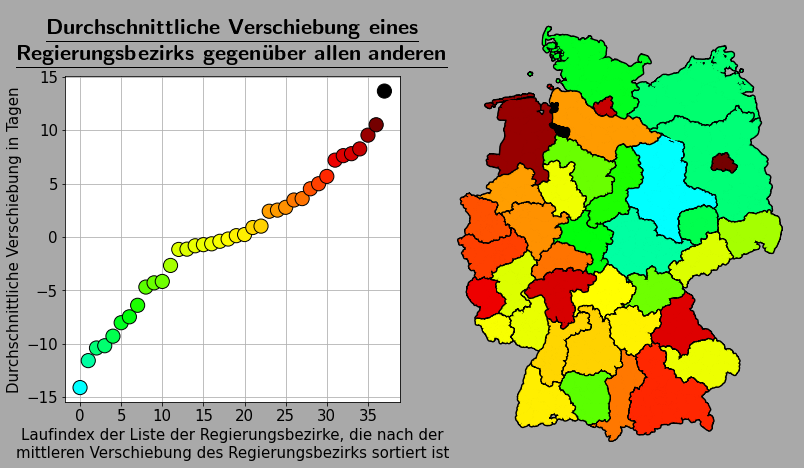

In [11]:
plt.figure(figsize=(6, 6), facecolor='darkgrey')    # enlarge plot
average_correlations_copy = list(average_correlations.values()).copy()
average_correlations_copy.sort()

plt.title(r"\textbf{\underline{Durchschnittliche Verschiebung eines}}"+"\n"+
          r"\textbf{\underline{Regierungsbezirks gegenüber allen anderen}}",
         fontsize=22, y=1.03, usetex=True)

plt.ylabel("Durchschnittliche Verschiebung in Tagen", fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Laufindex der Liste der Regierungsbezirke, die nach der\n"+
           "mittleren Verschiebung des Regierungsbezirks sortiert ist",
           fontsize=15)
plt.xticks(fontsize=15)
plt.grid()

colors = list()
for avg_correlation in average_correlations_copy:
    colors.append(color_scheme(avg_correlation, average_correlations_copy))
plt.scatter([i for i in range(len(average_correlations_copy))],
            average_correlations_copy, color=colors, zorder=2,
            s=200, edgecolors= "black",)

ax = plt.axes([1, -0.01, 0.82, 1.05], frameon=False) # [left, bottom, width, height]
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor('darkgrey')
i=0
for AdmUnitId, correlation in average_correlations.items():
    for AdmUnitID_county in districts[AdmUnitId]["counties"]:
        for polygon in counties_geography[AdmUnitID_county ]['geometry']:
            x,y = np.array(polygon).T
            plt.fill(x, y, zorder=i+3,
                     color=color_scheme(correlation, average_correlations_copy))
        for polygon in counties_geography[AdmUnitID_county ]['raw_geometry']:
            x,y = np.array(polygon).T
            plt.plot(x, y, color="black", zorder=i+2, linewidth=4)
    i+=1

os.chdir(".."), os.chdir(".."), os.chdir("..")    # move to correct directory
# check if the needed directory is available - otherwise create it
if not(os.path.isdir("results")): os.makedirs("results")
if not(os.path.isdir("results/Ergebnisse")): os.makedirs("results/Ergebnisse")
plt.savefig("results/Ergebnisse/average_shift_districts.png",
            facecolor="darkgrey", bbox_inches=Bbox([[-0.95,-0.2],[11,6.3]]))
os.chdir(cor_mx_by_pop_density_districts_directory)    # return to original directory

## Germany with probabiility how sure a county is behind

In [12]:
average_correlations = dict()
for row_index in range(len(correlation_matrizes[4])):
    row = correlation_matrizes[4][row_index]
    AdmUnitID = AdmUnitIds[row_index]
    # Because the row represents the shift of the second
    # county relative to the first, related to this row,
    # we need to take minus to get the average shift of the county
    # relative to all others
    average_correlations[AdmUnitID]=-(sum(row)/len(row))

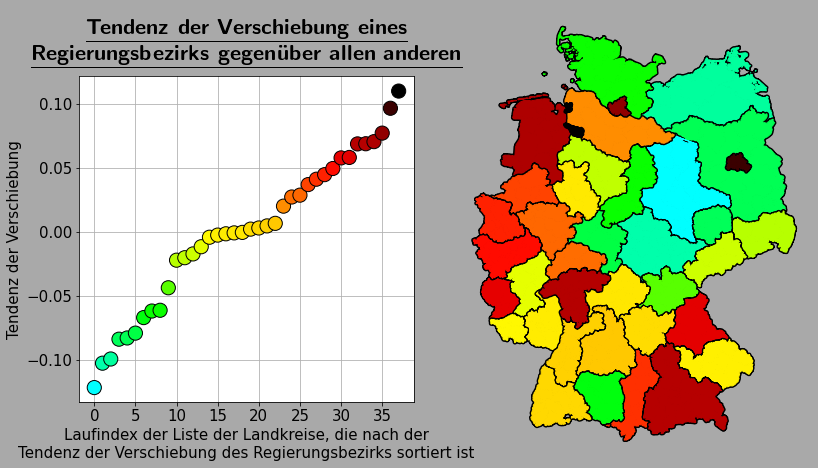

In [13]:
plt.figure(figsize=(6, 6), facecolor='darkgrey')    # enlarge plot
average_correlations_copy = list(average_correlations.values()).copy()
average_correlations_copy.sort()

plt.title(r"\textbf{\underline{Tendenz der Verschiebung eines}}"+"\n"+
          r"\textbf{\underline{Regierungsbezirks gegenüber allen anderen}}",
         fontsize=22, y=1.03, usetex=True)
plt.ylabel("Tendenz der Verschiebung", fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Laufindex der Liste der Landkreise, die nach der\n"+
           "Tendenz der Verschiebung des Regierungsbezirks sortiert ist", fontsize=15)
plt.xticks(fontsize=15)
plt.grid()

colors = list()
for avg_correlation in average_correlations_copy:
    colors.append(color_scheme(avg_correlation, average_correlations_copy))
plt.scatter([i for i in range(len(average_correlations_copy))],
            average_correlations_copy, s=200, edgecolors= "black",
            color=colors, zorder=2)

ax = plt.axes([1, -0.01, 0.82, 1.05], frameon=False) # [left, bottom, width, height]
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor('darkgrey')
i=0
for AdmUnitId, correlation in average_correlations.items():
    for AdmUnitID_county in districts[AdmUnitId]["counties"]:
        for polygon in counties_geography[AdmUnitID_county ]['geometry']:
            x,y = np.array(polygon).T
            plt.fill(x, y, zorder=i+3,
                     color=color_scheme(correlation, average_correlations_copy))
        for polygon in counties_geography[AdmUnitID_county ]['raw_geometry']:
            x,y = np.array(polygon).T
            plt.plot(x, y, color="black", zorder=i+2, linewidth=4)
    i+=1


os.chdir(".."), os.chdir(".."), os.chdir("..")    # move to correct directory
# check if the needed directory is available - otherwise create it
if not(os.path.isdir("results")): os.makedirs("results")
if not(os.path.isdir("results/Ergebnisse")): os.makedirs("results/Ergebnisse")
plt.savefig("results/Ergebnisse/positive_or_negative_shift_districts.png",
            facecolor="darkgrey", bbox_inches=Bbox([[-0.95,-0.2],[11,6.3]]))
os.chdir(cor_mx_by_pop_density_districts_directory)    # return to original directory